注：图可能有点不一样，因为图是基于if currentInfoGainRatio > bestInfoGain:生成的决策树画的，而后来改了下代码，改成了if currentInfoGainRatio >= bestInfoGain:，生成的树可能会不一样

# C4.5几乎和ID3算法一样，只是ID3基于信息增益来划分，每次选择特征时选择信息增益大的来划分，而C4.5选择信息增益比大的来划分

特征A对训练数据集D的信息增益比定义为其信息增益g(D,A)与训练数据集D关于特征A的值的熵HA(D)之比

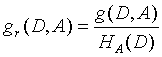

其中HA(D)定义如下，n是特征A取值的个数

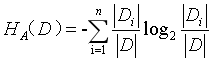

比起ID3的代码变化的地方：

增加了这句
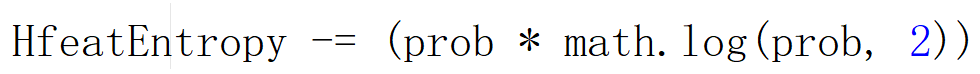
用于计算HA(D),其中prob=|Di|/|D|

和这句
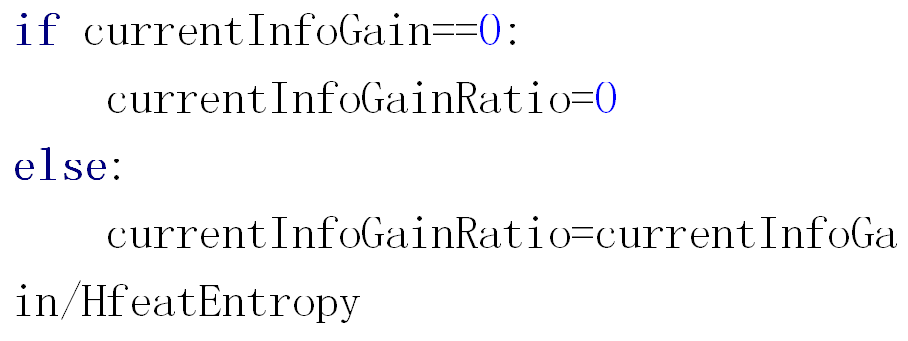
若当前数据集D中关于当前特征A只有1个取值，即D上特征A的取值全相同，此时prob=1，所以log（prob）=0，所以HfeatEntropy会等于0，在下面的除法中分母为0会出现错误。
不过当前数据集D中关于当前特征A只有1个取值时g(D,A)=0，所以HfeatEntropy=0时一定有currentInfoGain=0，反之亦然，所以只需要判断currentInfoGain是否为0即可。

In [12]:
import operator
import math


def create_data():
    dataSets = [['青年', '否', '否', '一般', '否'],
               ['青年', '否', '否', '好', '否'],
               ['青年', '是', '否', '好', '是'],
               ['青年', '是', '是', '一般', '是'],
               ['青年', '否', '否', '一般', '否'],
               ['中年', '否', '否', '一般', '否'],
               ['中年', '否', '否', '好', '否'],
               ['中年', '是', '是', '好', '是'],
               ['中年', '否', '是', '非常好', '是'],
               ['中年', '否', '是', '非常好', '是'],
               ['老年', '否', '是', '非常好', '是'],
               ['老年', '否', '是', '好', '是'],
               ['老年', '是', '否', '好', '是'],
               ['老年', '是', '否', '非常好', '是'],
               ['老年', '否', '否', '一般', '否'],
               ]
    labels = [u'年龄', u'有工作', u'有自己的房子', u'信贷情况', u'类别']

    # 返回数据集和每个维度的名称
    return dataSets, labels



class Node:
    def __init__(self, label=None, featureIndex=None ,feature_name=None, 
                 parentNode=None, leaf=False,entropy=0):
        
        self.label = label
        self.leaf = leaf  # 是否为叶结点
        self.featureIndex = featureIndex
        self.feature_name = feature_name
        self.parentNode = parentNode
        self.childNodeList = {}  # 存的是子结点的取值，如feature_name是身高，可能存的是高，矮
        self.entropy=entropy
        self.sampleLists=[]
        self.prune_visited=False 

    def predict(self,node,Xtest):
        if node.leaf:
            return node.label
        else:
            currentFeatIndex=node.featureIndex
            currentFeatVal=Xtest[currentFeatIndex]
            return self.predict(node.childNodeList[currentFeatVal],Xtest)



class dTree:
    def __init__(self, epsilon=0.1,alpha=0.3):
        self.epsilon = epsilon
        self.myTree = None
        self.completeDataSets=None
        self.completeAttrs=None
        self.leafNums=0
        self.alpha=alpha  #用于剪枝


    def treeGenerate(self,dataSets,labels):
        self.myTree=Node(parentNode='root')
        self.completeDataSets=dataSets.copy()
        self.completeAttrs=labels.copy()
        self.recursive(dataSets,labels,self.myTree)
        print("generate tree success!")


    def recursive(self, dataSets, labels, node=Node()):
        if self.isSameClass(dataSets):
            node.label = dataSets[0][-1]
            node.leaf = True
            node.entropy=self.calcEntropy(dataSets)
            node.sampleLists=dataSets
            self.leafNums+=1
            return
        if len(labels[:-1]) == 0:
            node.label = self.majorityClass(dataSets)
            node.leaf = True
            node.entropy=self.calcEntropy(dataSets)
            node.sampleLists=dataSets
            self.leafNums+=1
            return

        bestFeatIndex = self.chooseBestFeatureToSplit(dataSets, labels)
        node.featureIndex = bestFeatIndex
        node.feature_name = self.completeAttrs[bestFeatIndex]
        node.entropy=self.calcEntropy(dataSets)
        node.sampleLists=dataSets
        featList = [data[bestFeatIndex] for data in self.completeDataSets]
        uniqueFeatList = set(featList)
        for feat in uniqueFeatList:
            subNode = Node()
            node.childNodeList[feat]=subNode
            subNode.parentNode = node
            subDataSets = self.splitData(dataSets, bestFeatIndex, feat)
            if len(subDataSets) == 0:
                subNode.label = self.majorityClass(dataSets)
                subNode.leaf = True
                self.leafNums += 1
            else:
                subLabels = labels.copy()
                subLabels.remove(self.completeAttrs[bestFeatIndex])
                self.recursive(subDataSets, subLabels, subNode)



    def chooseBestFeatureToSplit(self, dataSets, labels):
        baseEntropy = self.calcEntropy(dataSets)
        m = len(dataSets)
        bestInfoGain = -math.inf
        bestFeatIndex = -1
        for i in range(len(labels) - 1):  # 遍历每个属性
            j=self.completeAttrs.index(labels[i])
            featList = [data[j] for data in dataSets]
            uniqueFeats = set(featList)  # 当前属性的取值
            newEntropy = 0
            HfeatEntropy = 0
            for feat in uniqueFeats:  # 遍历当前属性的每个取值
                subDataSets = self.splitData(dataSets, j, feat)
                prob = len(subDataSets) / m
                newEntropy += prob * self.calcEntropy(subDataSets)
                HfeatEntropy -= (prob * math.log(prob, 2))
            currentInfoGain = baseEntropy - newEntropy
            if currentInfoGain==0:
                currentInfoGainRatio=0
            else:
                currentInfoGainRatio=currentInfoGain/HfeatEntropy
            if currentInfoGainRatio >= bestInfoGain:
                bestInfoGain = currentInfoGainRatio
                bestFeatIndex = j
        return bestFeatIndex


    def splitData(self, dataSets, featIndex, featVals):
        subDataSets = [data for data in dataSets if data[featIndex] == featVals]
        return subDataSets


    def calcEntropy(self, dataSets):
        informationEnt = 0
        m = len(dataSets)
        classCountDict = self.classCount(dataSets)
        for key in classCountDict.keys():
            prob = classCountDict[key] / m
            if prob == 0.0:
                Ent = 0.0
            else:
                Ent = prob * math.log(prob,2)
            informationEnt -= Ent
        return informationEnt

    def isSameClass(self, dataSets):
        C = dataSets[0][-1]  # 第一个样本的类
        for data in dataSets:
            if C != data[-1]:
                return False
        return True


    def isSameValue(self, dataSets, labels):
        #！！！不能用把dataSets上所有的取值放到一个set里，然后来简单判断下set的长度是否等于labels的长度，以下为例子
        # case 1：
        #      dataSets=[['绿','高',1],['绿','高',1]]
        #      labels=['颜色','高度','类别']
        #      此时dataSets的set为（'绿','高',1）,set的长度与labels的长度一样，可以判定为dataSets所有样本取值相同，但还有其他情况
        # case 2：
        #      dataSets=[[1,'高',1],[1,'高',1]]
        #      labels=['长度','高度','类别']
        #      此时dataSets的set为（'高',1），set的长度就不与labels的长度一样了，但dataSets上所有样本取值仍然是相同的
        flag=True
        for i in range(len(labels)-1):
            value = []
            for data in dataSets:
                value.append(data[i])
            if len(set(value))!=1:
                flag=False
        return flag


    def majorityClass(self, dataSets):
        classCountDict = self.classCount(dataSets)
        sortedClassCount = sorted(classCountDict.items(), key=operator.itemgetter(1),reverse=True)
        return sortedClassCount[0][0]


    def classCount(self,dataSets):
        classCountDict = {}
        for data in dataSets:
            if data[-1] not in classCountDict.keys():
                classCountDict[data[-1]] = 1
            else:
                classCountDict[data[-1]] += 1
        return classCountDict


    def predict(self,Xtest):
        return self.myTree.predict(self.myTree,Xtest)


    def score(self,testDatas):
        #testDatas需要是至少有两个样本的list
        y=[data[-1] for data in testDatas]
        predictY=[]
        for Xtest in testDatas:
            predictY.append(self.predict(Xtest[:-1]))
        m=len(y)
        count=0
        for i in range(m):
            if y[i]==predictY[i]:
                count+=1
        accuracy=float(count/m)*100
        print(y)
        print(predictY)
        print("accuracy is "+str(accuracy)+"%")

        
#后剪枝
    def postPruning(self):
        count=0
        leafParentNode = self.getTheLeafParentNode(self.myTree)  #找到一个子结点全是叶结点的结点，并且该结点的prune_visited=False
        while leafParentNode.parentNode!='root':  #找到根结点时停止
            beforeLoss = self.compute_recursive(self.myTree)+self.alpha*self.leafNums
            tmpLeafChildNode = leafParentNode.childNodeList.copy()  #将该结点的子结点保存起来
            leafParentNode.childNodeList = {}  #先假设将子结点剪了
            afterLoss = self.compute_recursive(self.myTree)+self.alpha*(self.leafNums-len(tmpLeafChildNode)+1)
            if afterLoss > beforeLoss:  # 如果剪了后损失值更大了，就不剪
                leafParentNode.childNodeList = tmpLeafChildNode
            else:
                leafParentNode.leaf=True
                leafParentNode.label=self.majorityClass(leafParentNode.sampleLists)
                self.leafNums=self.leafNums-len(tmpLeafChildNode)+1
                print("prune node: %s"%(leafParentNode.feature_name))
                count+=1
            leafParentNode = self.getTheLeafParentNode(self.myTree)  #寻找下一个子结点全是叶结点的结点
        print("prune finished,cut %d node!"%count)


    def compute_recursive(self,tree):
        loss=0
        if tree.childNodeList:  #如果当前结点有子结点
            for featVal,childNode in tree.childNodeList.items():
                loss+=self.compute_recursive(childNode)
        else:   #当前结点为叶结点
            loss+=len(tree.sampleLists)*tree.entropy
        return loss


    def getTheLeafParentNode(self,tree):
        isAllChildNodeLeaf=True
        if tree.childNodeList:  #如果当前结点有子结点，即不是叶结点
            for key,childNode in tree.childNodeList.items():#遍历当前结点的所有子结点
                if childNode.prune_visited:
                    continue
                if childNode.childNodeList:  #当前迭代下的子结点如果还有子结点，即不是叶节点的话
                    isAllChildNodeLeaf=False
                    return self.getTheLeafParentNode(childNode)  #递归地对非叶结点调用此方法
            if isAllChildNodeLeaf and not tree.prune_visited:   #如果当前结点所有子结点都是叶结点
                tree.prune_visited=True
                return tree





In [13]:
firstDataSets,firstLabels=create_data()
firstMyTree=dTree()
firstMyTree.treeGenerate(firstDataSets,firstLabels)
firstMyTree.score(firstDataSets)
firstMyTree.postPruning()

generate tree success!
['否', '否', '是', '是', '否', '否', '否', '是', '是', '是', '是', '是', '是', '是', '否']
['否', '否', '是', '是', '否', '否', '否', '是', '是', '是', '是', '是', '是', '是', '否']
accuracy is 100.0%
prune finished,cut 0 node!


# 第一组数据生成的决策树

![image.png](./C4.5_tree_pics/Figure_1.png)

In [14]:
secondDataSets=[
['青绿','蜷缩','浊响','清晰','凹陷','硬滑',1],
['乌黑','蜷缩','沉闷','清晰','凹陷','硬滑',1],
['乌黑','蜷缩','浊响','清晰','凹陷','硬滑',1],
['青绿','蜷缩','沉闷','清晰','凹陷','硬滑',1],
['浅白','蜷缩','浊响','清晰','凹陷','硬滑',1],
['青绿','稍蜷','浊响','清晰','稍凹','软粘',1],
['乌黑','稍蜷','浊响','稍糊','稍凹','软粘',1],
['乌黑','稍蜷','浊响','清晰','稍凹','硬滑',1],
['乌黑','稍蜷','沉闷','稍糊','稍凹','硬滑',0],
['青绿','硬挺','清脆','清晰','平坦','软粘',0],
['浅白','硬挺','清脆','模糊','平坦','硬滑',0],
['浅白','蜷缩','浊响','模糊','平坦','软粘',0],
['青绿','稍蜷','浊响','稍糊','凹陷','硬滑',0],
['浅白','稍蜷','沉闷','稍糊','凹陷','硬滑',0],
['乌黑','稍蜷','浊响','清晰','稍凹','软粘',0],
['浅白','蜷缩','浊响','模糊','平坦','硬滑',0],
['青绿','蜷缩','沉闷','稍糊','稍凹','硬滑',0]]

secondLabels=[u'色泽', u'根蒂', u'敲声', u'纹理', u'脐部', u'触感',u'类别']


secondMyTree=dTree()
secondMyTree.treeGenerate(secondDataSets,secondLabels)
secondMyTree.score(secondDataSets)
secondMyTree.postPruning()

generate tree success!
[1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0]
accuracy is 100.0%
prune finished,cut 0 node!


# 第二组数据生成的决策树

![image.png](./C4.5_tree_pics/Figure_2.png)

In [15]:
thirdDataSets=[
['青绿', '蜷缩', '浊响', '清晰', '凹陷', '硬滑', 1],
['乌黑', '蜷缩', '沉闷', '清晰', '凹陷', '硬滑', 1],
['乌黑', '蜷缩', '浊响', '清晰', '凹陷', '硬滑', 1],
['青绿', '稍蜷', '浊响', '清晰', '稍凹', '软粘', 1],
['乌黑', '稍蜷', '浊响', '稍糊', '稍凹', '软粘', 1],
['青绿', '硬挺', '清脆', '清晰', '平坦', '软粘', 0],
['浅白', '稍蜷', '沉闷', '稍糊', '凹陷', '硬滑', 0],
['乌黑', '稍蜷', '浊响', '清晰', '稍凹', '软粘', 0],
['浅白', '蜷缩', '浊响', '模糊', '平坦', '硬滑', 0],
['青绿', '蜷缩', '沉闷', '稍糊', '稍凹', '硬滑', 0]]

thirdLabels=[u'色泽', u'根蒂', u'敲声', u'纹理', u'脐部', u'触感',u'类别']

thirdTestDataSets=[
['青绿','蜷缩','沉闷','清晰','凹陷','硬滑',1],
['浅白','蜷缩','浊响','清晰','凹陷','硬滑',1],
['乌黑','稍蜷','浊响','清晰','稍凹','硬滑',1],
['乌黑','稍蜷','沉闷','稍糊','稍凹','硬滑',0],
['浅白','硬挺','清脆','模糊','平坦','硬滑',0],
['浅白','蜷缩','浊响','模糊','平坦','软粘',0],
['青绿','稍蜷','浊响','稍糊','凹陷','硬滑',0]]

thirdMyTree=dTree()
thirdMyTree.treeGenerate(thirdDataSets,thirdLabels)
thirdMyTree.score(thirdDataSets)
thirdMyTree.postPruning()

generate tree success!
[1, 1, 1, 1, 1, 0, 0, 0, 0, 0]
[1, 1, 1, 1, 1, 0, 0, 0, 0, 0]
accuracy is 100.0%
prune finished,cut 0 node!


# 第三组数据生成的决策树

![image.png](./C4.5_tree_pics/Figure_3.png)

In [16]:
thirdMyTree.score(thirdTestDataSets)

[1, 1, 1, 0, 0, 0, 0]
[1, 1, 0, 0, 0, 0, 0]
accuracy is 85.71428571428571%
